In [1]:
import numpy as np
import matplotlib.pylab as plot
from astropy.io import ascii,fits
from scipy import interpolate
import grb_catalogs_copy
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
import math
from astropy.table import Table
import pandas as pd

In [2]:
## code to use when reading in GBM effective area in order to get data into the desired format
def getGBMdata(gbmfile=None):
    """Reads the GBM NaI effective area file and returns a numpy array
    with two columns ``energy`` and ``aeff``.
    Parameters
    ----------
    gbmfile : string
       Name of file that contains the GBM data.
    Returns
    ----------
    gbmdata : array 
    numpy array with two columns ``energy`` and ``aeff``
    """
    
    return np.genfromtxt(gbmfile,skip_header=2,names=('energy', 'aeff'))


In [3]:
## bit of useful code for interpolating in log space
def loginterpol(x,y,x1):

    f=interpolate.interp1d(np.log10(x),np.log10(y),bounds_error=False,fill_value="extrapolate",kind='linear')
    y1=10**f(np.log10(x1))

    return y1

def loginterpol2d(x,y,z,x1,y1):

    wz=np.where(z==0)[0]
    zz=z
    zz[wz]=1.
    f=interpolate.interp2d(x,y,np.log10(zz),bounds_error=False,fill_value="extrapolate",kind='linear')
    z1=10**f(x1,y1)

In [4]:
#read in GBM Trigger Catalog
trigfit=fits.open('gbmtrigcat.fits')
trig=trigfit[1].data

#read in GBM Burst Catalog
gbmfit=fits.open('gbmgrbcat_copy.fits')
gbm=gbmfit[1].data




In [5]:
## generate random positions on the sky with equal area probability
def random_sky(n=1):

    u=np.random.rand(n)
    v=np.random.rand(n)

    phi=2*np.pi*u
    theta=np.arccos(2*v-1.)

    dec=-np.degrees(theta-np.pi/2.)
    ra=np.degrees(np.pi*2-phi)

    return ra,dec

In [6]:
#function to match GRBs in the Trigger catalog to those in the grb catalog so that we can create an array of the arrays in both
#we will ultimately use this to compare the timescales of the trigger timescale and the peak flux interval

def match_catalogs_name(name1,name2):

    ind_dict = dict((q,e) for e,q in enumerate(name1))
    inter = set(ind_dict).intersection(name2)
    m1 = [ind_dict[element] for element in inter]
    print(np.shape(m1))
    
    ind_dict = dict((q,e) for e,q in enumerate(name2))
    inter = set(ind_dict).intersection(name1)
    m2 = [ind_dict[element] for element in inter]
    print(np.shape(m2))
    
    return m1,m2


In [7]:
#ordering the trig and gbm catalog so that they are in the same order
so=np.argsort(np.array(trig['NAME']))
trig=trig[so]
so=np.argsort(np.array(gbm['NAME']))
gbm=gbm[so]

#creating array of grbs
m1, m2 = match_catalogs_name(trig['NAME'],gbm['NAME'])

#defining our two samples of bursts that are found in both catalogs so that we can utilize them further down
trigbursts = trig[m1]
gbmbursts = gbm[m2]

print(trigbursts['NAME'])
print(gbmbursts['NAME'])

(2352,)
(2352,)
['GRB120920003' 'GRB160503567' 'GRB121220311' ... 'GRB120716712'
 'GRB170726794' 'GRB150622393']
['GRB120920003' 'GRB160503567' 'GRB121220311' ... 'GRB120716712'
 'GRB170726794' 'GRB150622393']


In [8]:
## read in the GBM Aeff
aeff_gbm = getGBMdata('/home/alyson/NASA/Simulation/BurstCube/Users/ajoens/gbm_effective_area.dat')

In [9]:
## separate GBM short & long GRBs
w=np.where(gbmbursts['FLUX_1024']>0)
gbmbursts=gbmbursts[w]
s=np.where((gbmbursts['T90'] <= 2.)&((gbmbursts['PFLX_SPECTRUM_STOP']-gbmbursts['PFLX_SPECTRUM_START'])>0))[0]
l=np.where(gbmbursts['T90'] > 2.)[0]
m=np.where(gbmbursts['PFLX_BEST_FITTING_MODEL'][s] == ' ')



In [10]:
#This code works just for GBM. Commenting it out so I can go back to it in case I mess up doing it for BurstCube


# #Integrating the best fit spectrum for each GRB in the energy range of 50-300 KeV to get max. observed photon flux. 
# #This will give us the photon flux in units of ph/cm^2/s. Currently only doing this for GBM and will then add in BurstCube
mo=gbmbursts['PFLX_BEST_FITTING_MODEL'][s]
# #f=np.zeros([len(s),nsims]) # produces an array of zeros with the given shape and type
pf=np.zeros(len(s))
gbmcr=np.zeros(len(s))
outE=np.logspace(np.log10(50),np.log10(300),100) # returns numbers spaced evenly on a log scale
for i in range(len(s)):
#     #for j in range(nsims):
#         #E=np.array(eng[w[j]+1:w[j+1]+1])
#         #AeffBC=loginterpol(E,aeffs['aeff'][w[j]+1:w[j+1]+1],outE)
         AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE) #eng[w[j]+1:w[j+1]+1])
        
#         #Aratio=(AeffBC/AeffGBM)
#         # not sure what *grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]] is and why we need it. I think we only need the model photon flux times the aeffGBM and we want it integrated over the energy range provided in outE
#         # this should give us an array of the maximum observed photon flux for GBM
         if mo[i]=='PFLX_PLAW':
             gbmcr[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]])*AeffGBM,outE)
             pf[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]]),outE)
#             #pf[i]=gbm['PFLX_PLAW_PHTFLUX'][s[i]]
         if mo[i]=='PFLX_COMP':
             gbmcr[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]])*AeffGBM,outE)
             pf[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]]),outE)
#             #pf[i]=gbm['PFLX_COMP_PHTFLUX'][s[i]]
         if mo[i]=='PFLX_BAND':
             gbmcr[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]])*AeffGBM,outE)
             pf[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]]),outE)
#             #pf[i]=gbm['PFLX_BAND_PHTFLUX'][s[i]]
         if mo[i]=='PFLX_SBPL':
             gbmcr[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM,outE)
             pf[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)
#             #pf[i]=gbm['PFLX_SBPL_PHTFLUX'][s[i]]
# print(np.shape(gbmcr))
# #pf = np.array(pf)
# gbmcr = np.array(gbmcr)
# #print(gbmcr)

In [11]:
#plot Batse[64] against pf to see if they are the same
flux=gbmbursts['FLUX_BATSE_64'][s]
fluxshape=np.shape(flux)
print(fluxshape)

# #Creating plot of peak flux versus counts for real and simulated GBM
# #print(np.log10(pf[w]))
# fig=plot.figure(figsize=(20,5))
# plot.subplot(1,2,1)
# plot.hist(pf,label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# plot.hist(flux,label='flux batse',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
# plot.xscale('log')
# plot.legend()
# plot.subplot(1,2,2)
# #plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
# #pf has been gathered from the GBM catalog
# plot.hist(pf,label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# # this is the simulated GBM
# plot.hist(flux,label='flux batse',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
# #plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
# plot.xscale('log')
# plot.legend()

# plot.show()

# plot.plot(pf,flux, linestyle='None', marker='o')
# plot.xscale('log')
# plot.yscale('log')
# plot.plot([1e-1,1e3],[1e-1,1e3])
# plot.show()

# #print(flux)
# #print(pf)

(339,)


In [12]:
#define probability
#p = np.array((np.arange(pf.shape[0])+1)**(-1.0))
p = np.array((np.arange(pf.shape[0])+1.5)**(-0.4))
p=p/sum(p)
#randomly sample from the array of peak fluxes found above using our probability function found above so we draw more low peak fluxes
# This is creating our "intrinsic" sample
r=np.random.choice(pf.shape[0], 1000, replace=True, p=p)
print(min(r),max(r))
simpfsample = np.array(pf[r])
simgbmcr = np.array(gbmcr[r])
#print(np.shape(simpfsample))
#print(simpfsample)
#print(r)

0 337


0.001821401561192068 0.015933277216497444


(array([259.,  48.,  16.,   7.,   4.,   2.,   1.,   1.,   0.,   1.]),
 array([0.0018214 , 0.00323259, 0.00464378, 0.00605496, 0.00746615,
        0.00887734, 0.01028853, 0.01169971, 0.0131109 , 0.01452209,
        0.01593328]),
 <a list of 10 Patch objects>)

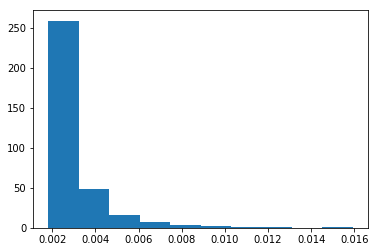

In [13]:
print(min(p),max(p))
plot.hist(p)

In [14]:
# we want to solve for the number of detected counts. We need to create two more arrays- 1 for exposure and the other for interval.
#Interval is given in the GBM catalog however we need to know exposure. This should be found from the exposure map for each burst.
#this all together will give us the number of source photons

## setup GBM
gbm_pointings = {'01': ('45:54:0','20:36:0'),
            '02': ('45:6:0','45:18:0'),
            '03': ('58:24:0','90:12:0'),
            '04': ('314:54:0','45:12:0'),
            '05': ('303:12:0','90:18:0'),
            '06': ('3:24:0','89:48:0'),
            '07': ('224:54:0','20:24:0'),
            '08': ('224:36:0','46:12:0'),
            '09': ('236:36:0','90:0:0'),
            '10': ('135:12:0','45:36:0'),
            '11': ('123:42:0','90:24:0'),
            '12': ('183:42:0','90:18:0')}

fermi = Spacecraft(gbm_pointings,window=0.1)

res = 250
rr,dd = np.meshgrid(np.linspace(0,360,res,endpoint=False),np.linspace(-90,90,res))
exposure_positions = np.vstack([rr.ravel(),dd.ravel()])
gbm_exposures = np.array([[ detector.exposure(position[0],position[1]) for position in exposure_positions.T] 
                      for detector in fermi.detectors])

In [15]:
#using SkyCoord to convert coordinates to degrees and solve for distances.
def separation(ra1,dec1,ra2,dec2):

    c=SkyCoord(ra=ra1*u.deg,dec=dec1*u.deg)
    d=SkyCoord(ra=ra2*u.deg,dec=dec2*u.deg)
    dist=c.separation(d)
    dist=dist.value

    return dist

In [16]:
# now that GBM's pointings are set up we will throw GRBs at it and determine it's exposure for each GRB. 
#generate GRBs and throw them at GBM

def throw_grbs(fermi,minflux,maxflux):
    
    nsims=int(np.round(len(simpfsample))) 
    ra,dec=random_sky(nsims)
    ra=np.array(ra)-180
    dec=np.array(dec)
    #sigma=0.65,mean=1.5
 
    #change the sigma and mean in order to create a log fit for simulated GBM. Automate this fit.
    #flux=np.random.lognormal(size=nsims,sigma=0.55,mean=0.6)*(np.log10(maxflux)-np.log10(minflux))+np.log10(minflux)

    #GBM exposures for each random GRB. Believe this is an array with the different exposures for each detector
    randgbmexposures = np.array([[detector.exposure(ra[i],dec[i]) for i in range(nsims)] for detector in fermi.detectors])
 #   print("randgbmexposures=", randgbmexposures)
 
    #Order randgbmexposures into descending order
    for column in randgbmexposures.T:
        newrandgbm = -np.sort(-randgbmexposures.T) 
    gbmexposures = np.transpose(newrandgbm)
   # print("gbmexposures=",gbmexposures)
    

    #Select the second highest value. 
    #We will use this to ensure the second highest exposure detector has a sig >4.5
    secondhighestgbm = gbmexposures[1,:]
 #   print("Second highest =", secondhighest)

        
    return gbmexposures, secondhighestgbm, randgbmexposures

In [17]:
#define the peak flux interval using the trigger catalog
msinterval = trigbursts['Trigger_Timescale'][s] 
interval = msinterval/1000

#print(interval)


In [18]:
#trigvsgbm = plot.scatter(triginterval, interval)

In [19]:
#triggertimescale = plot.plot(triginterval)

In [20]:
#gbmtrigger = plot.plot(interval)

In [21]:
#flux=simpf this is in ph/sec
flux=simpfsample
minflux=min(flux)
maxflux=max(flux)
gbmexposures, secondhighest, randgbmexposures = throw_grbs(fermi,minflux,maxflux)

#sechighestsize=np.shape(secondhighest)
#print(sechighestsize)
#execute function defined above
#throw_grbs(fermi,minflux,maxflux,pf)

In [22]:
#Solve for the number of detected counts which will equal our source photons
#Should this really be multiplied by pf or should it be multiplied by flux? pf is calculated from GBM catalog#
#secondhighest=1
source = simgbmcr*secondhighest*interval[r]
#sourcetrig = simgbmcr*secondhighest*triginterval[r]
#q=np.shape(simpfsample)
#print(q)
#y=np.shape(secondhighesit)
#print(y)
x=np.shape(interval[r])
print(x)
#print(source)
#print(sourcetrig)
#print(type(interval[r]))
#print(type(secondhighest))
#print(type(simgbmcr))
#print(simpfsample)

(1000,)


In [23]:
#Assuming a background count rate. units: cts/s
bckgrd=300
#scale the background count rate 
scaledbckgrd = bckgrd*secondhighest*interval[r]
#print(scaledbckgrd)


#scaledbckgrdtrig = bckgrd*secondhighest*triginterval[r]
#print(scaledbckgrdtrig)

In [24]:
#calculate the significance of the second highest exposure detector. If the significance is greater than 4.5 sigma than the burst is detectable.
#creating an array of zeros that I can 
detect = np.zeros(len(simpfsample))
#detecttrig = np.zeros(len(simpfsample))

for u in range(len(simpfsample)):
    sig = source[u] / (math.sqrt(source[u] + scaledbckgrd[u]))
    if sig > 4.5:
        detect[u] = 1.0
    else:
        detect[u] = 0.0

#print(detect)


#for tr in range(len(simpfsample)):
#    sig = sourcetrig[tr] / (math.sqrt(sourcetrig[tr] + scaledbckgrdtrig[tr]))
#    if sig > 4.5:
#        detect[tr] = 1.0
#    else:
#        detect[tr] = 0.0

#print(detecttrig)


/home/alyson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [25]:
det = np.where(detect == 1)[0]
print(len(det))
ratio = len(det) / len(detect)
print(ratio)

308
0.308


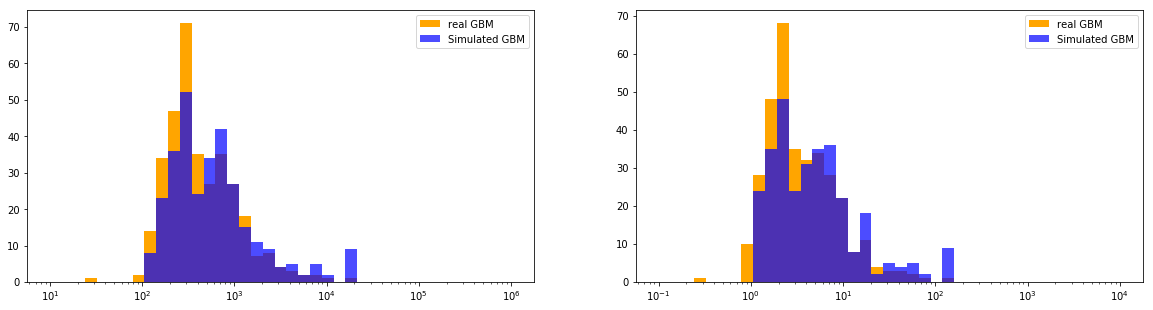

In [26]:
#Creating plot of peak flux versus counts for real and simulated GBM
w=np.where(pf>0)[0]
wg = np.where(simgbmcr*detect>0)[0]
#wgtrig = np.where(simgbmcr*detecttrig>0)[0]
#print(np.log10(pf[w]))
fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(gbmcr[w],label='real GBM',bins=np.logspace(1,6,40),color='orange')
plot.hist(simgbmcr[wg],label='Simulated GBM',bins=np.logspace(1,6,40),alpha=0.7,color='blue')
#plot.hist(simgbmcr[wgtrig],label='Simulated GBM trigger interval',bins=np.logspace(1,6,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
plot.hist(pf[w],label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# this is the simulated GBM
plot.hist(simpfsample[wg],label='Simulated GBM',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()

plot.show()
        